# bQTL Combo Modisco Run \#2 (August 24, 2018)
Description:
- 5 tasks:

    ```
    GM12878-JUND-human-ENCSR000EYV-optimal_idr.narrowPeak.gz
    GM12878-JUND-human-ENCSR000DYS-optimal_idr.narrowPeak.gz
    GM12878-RELA-human-ENCSR000EAG-optimal_idr.narrowPeak.gz
    GM12878-SPI1-human-ENCSR000BGQ-optimal_idr.narrowPeak.gz
    GM12878-STAT1-human-ENCSR332EYT-optimal_idr.narrowPeak.gz
    ```
- exclude CTCF, but did not re-run deeplift, reused scores
- Used `target_fdr=0.01`
- Ran deeplift/modisco on pre-training test set with 64k 1k len sequences
- With newly-added default `min_seqlets_per_task=500` for determining laplace threshold

In [1]:
from __future__ import print_function, division
%matplotlib inline


import os

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError: 
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)
import h5py

Theano version: 1.0.2
2.7.15 |Anaconda, Inc.| (default, May  1 2018, 23:32:55) 
[GCC 7.2.0]


Using cuDNN version 7001 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:08:00.0)


laplace for the 9 tasks:
![laplace_b 0](figures/laplace_0.png)
![laplace_b 1](figures/laplace_1.png)
![laplace_b 2](figures/laplace_2.png)
![laplace_b 3](figures/laplace_3.png)
![laplace_b 4](figures/laplace_4.png)

[logs](logs/modisco.log)


Metaclusters heatmap


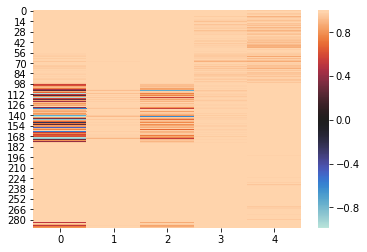

metacluster_0
activity pattern: [0 0 0 1 0]
metacluster_0 pattern_0
total seqlets: 104
Task 0 hypothetical scores:


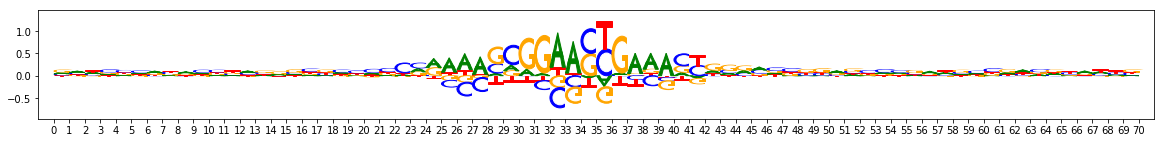

Task 0 actual importance scores:


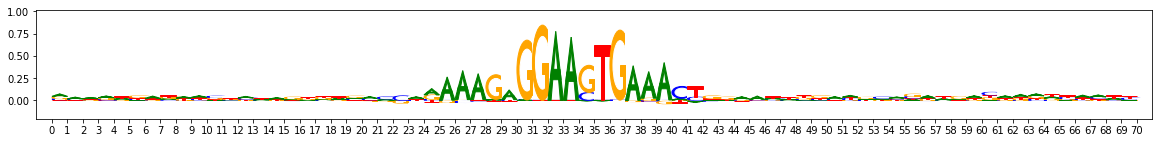

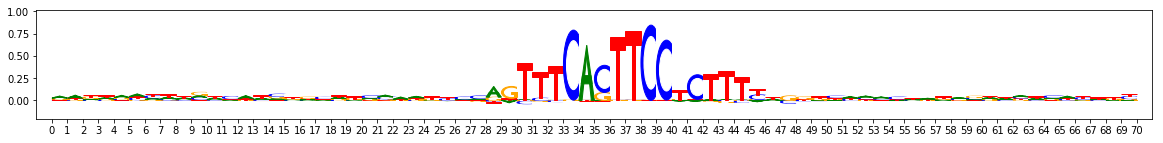

onehot, fwd and rev:


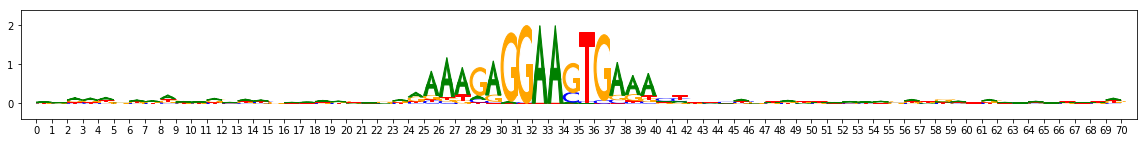

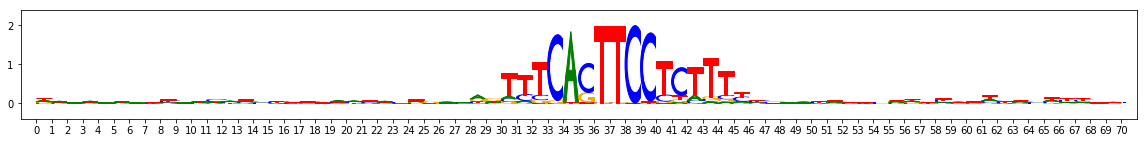

In [3]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["rev"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()